# Transfer Learning part 1 : Feature Extraction 
transfer learning is levaraging a models working esisting architechtures 
and learned patterns for our own problem

there are two main benefits :-
  1. Can levarage an existing nueral network proven to work for our exhistin problem 
  2. It can adapt the learning of the other model to our data to work with it
   

In [1]:
!nvidia-smi

Fri Feb 25 16:27:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Getting the data

In [2]:
import zipfile 
#https://www.kaggle.com/dansbecker/food-101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

#unzip the data 
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-02-25 16:27:29--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.189.128, 108.177.125.128, 142.250.157.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.189.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   211MB/s    in 0.8s    

2022-02-25 16:27:30 (211 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os 

#walk through the 10 percent data directory 
for dirpath, dirnames , filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are{len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

There are2 directories and 0 images in '10_food_classes_10_percent'
There are10 directories and 0 images in '10_food_classes_10_percent/train'
There are0 directories and 75 images in '10_food_classes_10_percent/train/ramen'
There are0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are

##Creating  the loaded data (prepairing the data)

In [4]:
#Setup the data inputs 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

IMG_SHAPE = (224 , 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("training images:")
train_data_10_percent= train_datagen.flow_from_directory(train_dir,
                                                         target_size=IMG_SHAPE,
                                                         batch_size= BATCH_SIZE,
                                                         class_mode = "categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                        target_size=IMG_SHAPE,
                                                        batch_size = BATCH_SIZE,
                                                        class_mode = "categorical")

training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


##Settin up call backs 

callbacks are extra functionality you can add tp your models
to be perform during or after training. Some of the most
popular callbacks:

* Tracking experiment with the tensorflow callback
* Model Checkpoint  with the ModelCheckpoint callback
* Stopping a model from training (before it train too long and overfits)
   with the EarlyStopping callbacks 

In [5]:
import datetime

def create_tf_callback(dir_names, exp_name):
  log_dir = dir_names + "/" + exp_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving Tensorflow log files to: {log_dir}")
  return tensorboard_callback

#Creating model using tensorflow hub
in the past weve used Tensorflow to create our own models layers by layers from scratch
now we're going to do a similar process, except the majority of our model's layers are going come from tensorflow hub
we can access pretrained models on : http://tfhub.dev/

In [6]:
#lets compare the following two models\

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"



In [7]:
#import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers



In [8]:
#Create the model

def create_model(model_url , num_classes=10):
  """
  Takes a tensorflow hub model 

  Args:
    model_url (str):A Tensorflow Hub feature extraction URL
    num_classes (int): Number of output neurons in the output layers 
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled keras Sequential model with model_url as features extraction 
    layers and Dense output layers with num_classes output neurons.
  """
  #Download the model 
  feature_extraction_layers = hub.KerasLayer(model_url,
                                             trainable=False,
                                             name= "feature_extraction_layer",
                                             input_shape =IMG_SHAPE+(3,)) 
  
  #Create our own model
  model = tf.keras.Sequential([
                               feature_extraction_layers,
                               layers.Dense(num_classes , activation="softmax", name="output_layer")
  ])

  return model


###Creating and testing resnet Tensorflow Hub features Extraction model

In [9]:
#Create the resnet model
resnet_model = create_model(resnet_url,
                            num_classes= train_data_10_percent.num_classes)


In [10]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])


In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [ ]:
#Let's fit our resnet model to the data(10 percent of 10 classes)
resnet_history  = resnet_model.fit(train_data_10_percent,
                                   epochs = 5,
                                   steps_per_epoch = len(train_data_10_percent),
                                   validation_data =test_data_10_percent,
                                   validation_steps=len(test_data_10_percent),
                                   callbacks = [create_tf_callback(dir_names="tensorflow_hub",
                                                                    exp_name="resnet50V2")])

Saving Tensorflow log files to: tensorflow_hub/resnet50V2/20220225-162750
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.8455 - accuracy: 0.3907 - val_loss: 1.1765 - val_accuracy: 0.6472
Epoch 2/5
24/24 [==============================] - 21s 907ms/step - loss: 0.8961 - accuracy: 0.7440 - val_loss: 0.8661 - val_accuracy: 0.7176
Epoch 3/5
24/24 [==============================] - 22s 936ms/step - loss: 0.6294 - accuracy: 0.8293 - val_loss: 0.7447 - val_accuracy: 0.7596
Epoch 4/5
24/24 [==============================] - 21s 908ms/step - loss: 0.4827 - accuracy: 0.8680 - val_loss: 0.6897 - val_accuracy: 0.7784
Epoch 5/5
24/24 [==============================] - 21s 906ms/step - loss: 0.3835 - accuracy: 0.9147 - val_loss: 0.6564 - val_accuracy: 0.7820


In [ ]:
import matplotlib.pyplot as plt

#plot the validaiton and atraining curve 
def plot_loss_curve(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot the loss
  plt.plot(epochs , loss , label="traning_loss")
  plt.plot(epochs, val_loss , label="val_loss")
  plt.title("loss")
  plt.xlabel("Epochs")
  plt.legend();

  #plot accuracy
  plt.figure()
  plt.plot(epochs , accuracy , label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

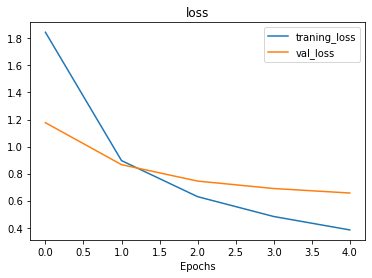

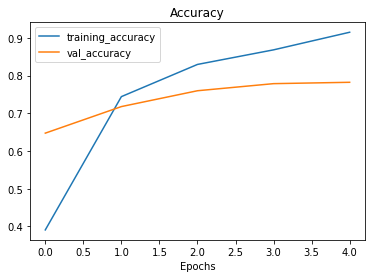

In [ ]:
plot_loss_curve(resnet_history)

#Creating the efficient-net 

In [ ]:
#creating the model
efficientnet_model = create_model(model_url = efficientnet_url,
                                  num_classes= train_data_10_percent.num_classes)

#compile the model 
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# fit the Efficientnet model to 10% of traning  data
efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                              epochs= 5,
                                              steps_per_epoch=len(train_data_10_percent),
                                              validation_data = test_data_10_percent,
                                              validation_steps=len(test_data_10_percent),
                                              callbacks=[create_tf_callback(dir_names="tensorflow_hub",
                                                                    exp_name="efficientnet50V2")])

In [ ]:
plot_loss_curve(efficientnet_history)

##Different types of transfer learning 